# Getting Started
This guide will get you started using LVM reduced data products on the Flatiron Institute's BinderHub.

BinderHub is like using Jupyter notebooks. But there are some important things you should know:
1. Only things you store in `home/` will be saved. Anything else is deleted when the server shuts down.
2. You can store only 1 TB of data (per person) on this BinderHub.
3. The memory is limited to XXX GB. If you need more than that, contact Andy Casey (acasey@flatironinstitute.org).
4. It is easy to get additional Python packages installed. Just contact Andy Casey (acasey@flatironinstitute.org).
5. You can only run one notebook at a time. If you encounter some issue like "your server is already running" but you don't think you have an instance running, navigate to https://binder.flatironinstitute.org/ and select "Check your currently running server".

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import matplotdrip

DATA = Path("lvm/1.2.0/1027XX/1027920/60677/lvmSFrame-00032150.fits")
assert DATA.is_file()

rng = np.random.default_rng(0)

plt.style.use("drip")

# Turn off latex plotting bc it's a bit annoying in colab but my style sheet uses it by default
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [3]:
with fits.open(DATA) as data_file:

  # Header
  header = data_file[0].header

  # Flux and inverse variance
  # These fluxes are calibrated & sky subtracted
  flux = data_file[1].data
  ivar = data_file[2].data

  # Sky
  sky = data_file[6].data

  # Wavelengths
  wave = data_file[4].data

  # LSF
  lsf = data_file[5].data

  # has RA, Dec, Fibre type, etc.
  slitmap = data_file[-1].data

all_ra = slitmap.field("ra")
all_dec = slitmap.field("dec")

In [4]:
# header # Uncomment to display header (it's long)

In [5]:
# We don't need the standard or sky fibres probably

science_inds = np.where(slitmap.field("targettype") == "science")[0]
standard_inds = np.where(slitmap.field("targettype") == "standard")[0]
sky_inds = np.where(slitmap.field("targettype") == "SKY")[0]

print(f"{len(science_inds)} science fibres")
print(f"{len(standard_inds)} standard fibres")
print(f"{len(sky_inds)} sky fibres")

science_flux = flux[science_inds, :]
ra = all_ra[science_inds]
dec = all_dec[science_inds]

1801 science fibres
24 standard fibres
119 sky fibres


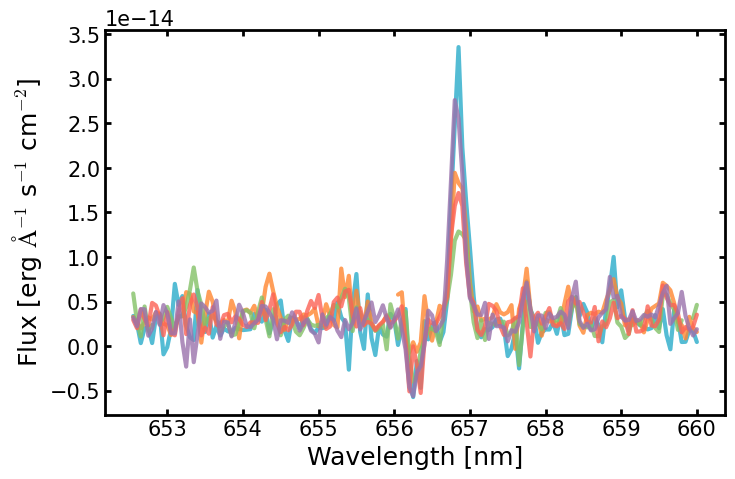

In [6]:
# Plot some random spectra near Halpha

Halpha_idx = np.argmin(np.abs(wave - 6563))
n_pix = 150
l_i = Halpha_idx - n_pix // 2
u_i = Halpha_idx + n_pix // 2

fig, ax = plt.subplots(figsize=[8, 5], dpi=100)

for ci, i in enumerate(rng.choice(np.arange(len(science_inds)), 5)):
  ax.plot(wave[l_i:u_i]/10, science_flux[i, l_i:u_i], c=f"C{ci}", alpha=0.8)

ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel(r"Flux [erg $\rm{\AA}^{-1}$ s$^{-1}$ cm$^{-2}$]")

plt.show()

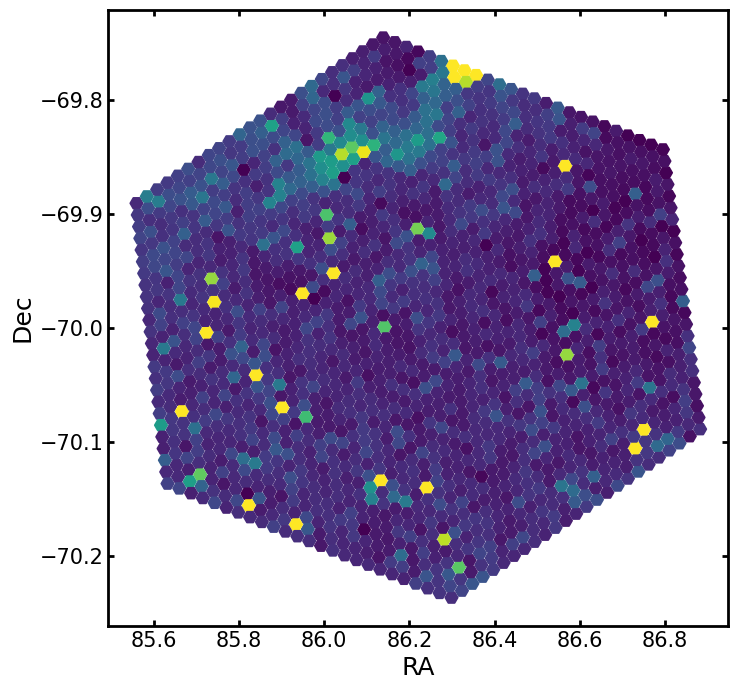

In [9]:
# Make a integrated flux near Halpha plot
integrated_flux = np.nansum(science_flux[:, l_i:u_i], axis=1)

vmin, vmax = np.nanpercentile(integrated_flux, q=(1, 99)) # There are fibres contaminated by bright stars

fig, ax = plt.subplots(figsize=[8,8], dpi=100)
ax.scatter(ra, dec, c=integrated_flux, vmin=vmin, vmax=vmax, s=75, marker="H")
ax.set_aspect("auto")
ax.set_xlabel(r"RA")
ax.set_ylabel(r"Dec")
plt.show()

# Doing it faster/easier

In [10]:
from lvm_tools import LVMTile

tile = LVMTile.from_file(DATA)
print(tile)

LVMTile (0x7feb04e767b0):
    Filename:        lvmSFrame-00032150.fits
    Exposure:        32150
    DRP version:     1.2.0
    Tile ID:         1027920
    Data size:        362MB
    Dimensions:       tile: 1, spaxel: 1801, wavelength: 12401
    Coordinates:
        tile          (tile)                       int64    0kB    []
        spaxel        (spaxel)                     int64    14kB   []
        wavelength    (wavelength)                 float32  48kB   [Angstrom]
        mjd           (tile)                       float64  0kB    [day]
        ra            (tile, spaxel)               float64  14kB   [deg]
        dec           (tile, spaxel)               float64  14kB   [deg]
        fibre_id      (tile, spaxel)               int64    14kB   []
        ifu_label     (tile, spaxel)               <U5      35kB   []
        fibre_status  (tile, spaxel)               int64    14kB   []
    Data:
        flux          (tile, spaxel, wavelength)   float32  85MB   DaskArray<chun

This uses `xarray` with the `Dask` backend for lazy loading. You can also load many tiles into an `LVMTileCollection` and it will act like one unified table.

This is especially useful when you have a LOT of tiles, but you know you want to make certain cuts, maybe in wavelength. Then we can cut before loading into memory!

In [11]:
from lvm_tools import LVMTileCollection

tiles_list = [tile] # Pretend it's a list of multiple LVMTile objects which you read in from many DRP files
tiles = LVMTileCollection.from_tiles(tiles_list)

Making the same plots as before:

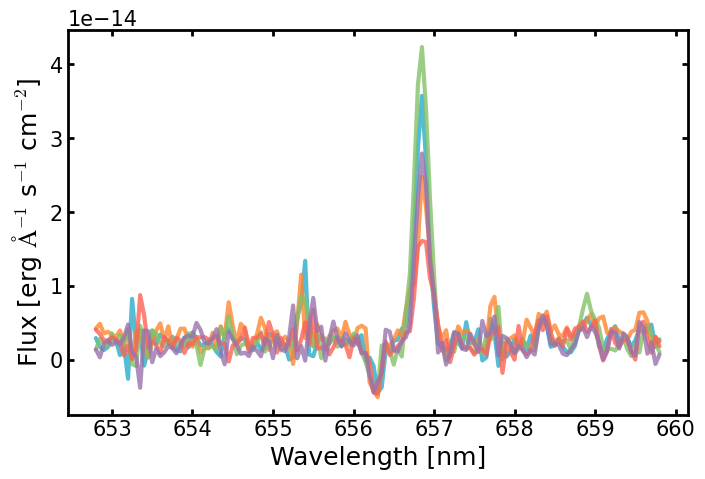

In [12]:
# Plot some random spectra near Halpha

Halpha = 6563
wave_extent = 35
data_near_halpha = tiles.data.sel(wavelength=slice(Halpha-wave_extent, Halpha+wave_extent)) # Slice by wavelength not index is nice too

fig, ax = plt.subplots(figsize=[8, 5], dpi=100)

for ci, i in enumerate(rng.choice(np.arange(len(science_inds)), 5)):
  # Note the extra index on tiles.data["flux"], which is an index over tiles
  ax.plot(data_near_halpha["wavelength"]/10, data_near_halpha["flux"][0, i, :], c=f"C{ci}", alpha=0.8)

ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel(r"Flux [erg $\rm{\AA}^{-1}$ s$^{-1}$ cm$^{-2}$]")

plt.show()

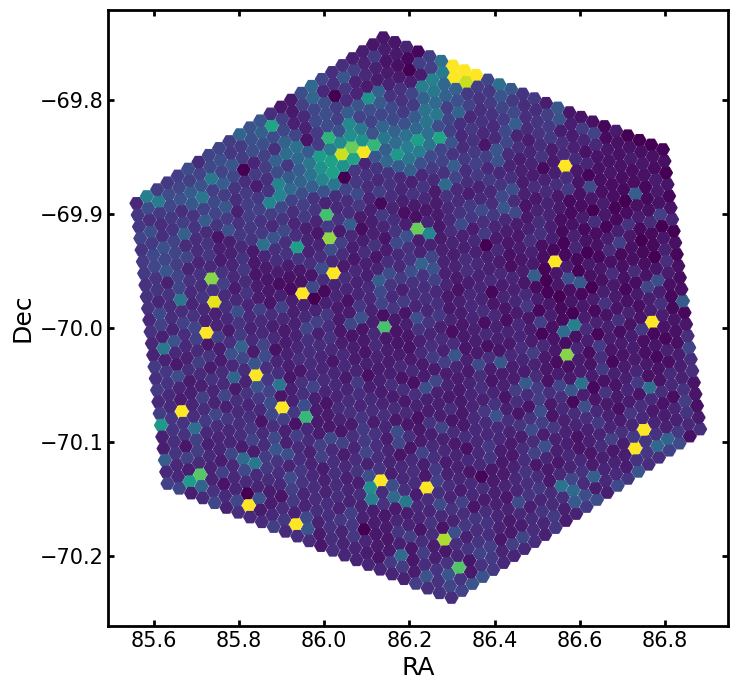

In [14]:
# Make a integrated flux near Halpha plot
integrated_flux = np.nansum(data_near_halpha["flux"][0, :, :], axis=1)

vmin, vmax = np.nanpercentile(integrated_flux, q=(1, 99)) # There are fibres contaminated by bright stars

fig, ax = plt.subplots(figsize=[8,8], dpi=100)
ax.scatter(ra, dec, c=integrated_flux, vmin=vmin, vmax=vmax, s=75, marker="H")
ax.set_aspect("auto")
ax.set_xlabel(r"RA")
ax.set_ylabel(r"Dec")
plt.show()

Looking up data by RA, Dec, or by field/fiber/mjd in terms of which tiles to even look at is probably done best with some `lvmvis` API thing. You may want to ask Ivan Katkov about that. I'm a bit unsure since I usually pick things by object.

Once you have a bunch of DRP files, finding things by RA, Dec, fiber, mjd would be super easy in `lvm_tools`, similar to how I sliced by wavelength without yet loading the data to memory above. That stuff is all available entries in the `xarray` table encapsulated by `LVMTile` and `LVMTileCollection`.

It's a bit contrived because I only have one tile, but here is an example of hunting for a tile by mjd:

In [15]:
# Looking for what the mjd of our tile is
print(tiles.data["mjd"].values)

[60677.3500221]


In [16]:
# Imagine we had many tiles and had a target mjd in mind a priori
target_mjd = 60651.2

closest_tile_to_target = tiles.data.isel(tile=(np.abs(tiles.data.mjd - target_mjd)).argmin())
print(closest_tile_to_target)

<xarray.Dataset> Size: 380MB
Dimensions:       (spaxel: 1801, wavelength: 12401)
Coordinates:
  * spaxel        (spaxel) int64 14kB 0 1 2 3 4 5 ... 1796 1797 1798 1799 1800
    ra            (spaxel) float64 14kB 86.3 86.32 86.35 ... 85.63 85.61 85.58
    dec           (spaxel) float64 14kB -70.24 -70.23 -70.22 ... -69.88 -69.88
    fibre_id      (spaxel) int64 14kB 3 4 5 6 7 8 ... 1939 1940 1941 1942 1943
    ifu_label     (spaxel) <U5 36kB 'Sci1' 'Sci1' 'Sci1' ... 'Sci3' 'Sci3'
    fibre_status  (spaxel) int64 14kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * wavelength    (wavelength) float32 50kB 3.6e+03 3.6e+03 ... 9.8e+03 9.8e+03
    tile          int64 8B 32150
    mjd           float64 8B 6.068e+04
Data variables:
    flux          (spaxel, wavelength) float32 89MB dask.array<chunksize=(1801, 12401), meta=np.ndarray>
    i_var         (spaxel, wavelength) float32 89MB dask.array<chunksize=(1801, 12401), meta=np.ndarray>
    lsf_sigma     (spaxel, wavelength) float64 179MB dask

Or hunting by RA, Dec

In [17]:
target_ra = 97.3
target_dec = 4.4

stacked = tiles.data.stack(fibre=('tile', 'spaxel')) # Tile and spaxel are not independent coordinates, I have both for convenience

cos_dec = np.cos(np.radians(target_dec))
dist_sq = ((stacked.ra - target_ra) * cos_dec)**2 + (stacked.dec - target_dec)**2
idx = dist_sq.argmin(dim='fibre')
closest_ra_dec_to_target = stacked.isel(fibre=idx)

print(closest_ra_dec_to_target)

<xarray.Dataset> Size: 261kB
Dimensions:       (wavelength: 12401)
Coordinates:
  * wavelength    (wavelength) float32 50kB 3.6e+03 3.6e+03 ... 9.8e+03 9.8e+03
    mjd           float64 8B 6.068e+04
    ra            float64 8B 86.14
    dec           float64 8B -69.75
    fibre_id      int64 8B 1920
    ifu_label     <U5 20B 'Sci3'
    fibre_status  int64 8B 0
    fibre         object 8B (np.int64(32150), np.int64(1777))
    tile          int64 8B 32150
    spaxel        int64 8B 1777
Data variables:
    flux          (wavelength) float32 50kB dask.array<chunksize=(12401,), meta=np.ndarray>
    i_var         (wavelength) float32 50kB dask.array<chunksize=(12401,), meta=np.ndarray>
    lsf_sigma     (wavelength) float64 99kB dask.array<chunksize=(12401,), meta=np.ndarray>
    mask          (wavelength) uint8 12kB dask.array<chunksize=(12401,), meta=np.ndarray>
